In [1]:
%%sql -d standard
SELECT
  timestamp,
  borough,
  latitude,
  longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
ORDER BY
  timestamp DESC
LIMIT
  15

timestamp,borough,latitude,longitude
2017-02-20 23:55:00,BROOKLYN,40.62192,-73.936134
2017-02-20 23:45:00,MANHATTAN,40.855556,-73.92918
2017-02-20 23:35:00,QUEENS,40.750763,-73.86628
2017-02-20 23:30:00,BROOKLYN,40.728992,-73.95067
2017-02-20 23:25:00,MANHATTAN,40.83806,-73.94665
2017-02-20 23:20:00,,40.656914,-73.95315
2017-02-20 23:20:00,,40.696865,-73.83717
2017-02-20 23:15:00,QUEENS,40.748993,-73.89687
2017-02-20 23:15:00,BRONX,40.852863,-73.90093
2017-02-20 23:10:00,,40.63757,-74.01457


In [2]:
%%sql --module nyc_collisions
SELECT
  IF(borough = 'MANHATTAN', 1, 0) AS is_mt,
  latitude,
  longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  LENGTH(borough) > 0 AND latitude IS NOT NULL AND longitude IS NOT NULL AND borough != "BRONX"
ORDER BY
  RAND()
LIMIT
  10000

In [3]:
import datalab.bigquery as bq
nyc_cols = bq.Query(nyc_collisions).to_dataframe(dialect='standard').as_matrix()
print "Found " + str(len(nyc_cols)) + " records."

Found 10000 records.


In [14]:
import numpy as np
is_mt = nyc_cols[:,0].astype(np.int32)
latlng = nyc_cols[:,1:3].astype(np.float32)
print "Is Manhattan: " + str(is_mt)
print "\nLat/Lng: \n\n" + str(latlng)

Is Manhattan: [1 0 0 ..., 1 0 1]

Lat/Lng: 

[[ 40.72271729 -74.00444794]
 [ 40.6652565  -73.73954773]
 [ 40.64478302 -73.91982269]
 ..., 
 [ 40.75652695 -73.99401855]
 [ 40.72013855 -73.82061005]
 [ 40.75281525 -73.97000885]]


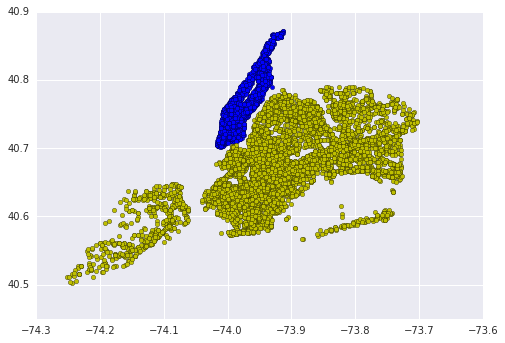

In [15]:
import matplotlib.pyplot as plt
lat = latlng[:,0]
lng = latlng[:,1]
plt.scatter(lng[is_mt == 1], lat[is_mt == 1], c='b')
plt.scatter(lng[is_mt == 0], lat[is_mt == 0], c='y')
plt.show()

In [60]:
# standardization
from sklearn.preprocessing import MinMaxScaler
latlng_std = MinMaxScaler().fit_transform(latlng)

# for training
latlng_train = latlng_std[0:7999]
is_mt_train = is_mt[0:7999]

# for test
latlng_test = latlng_std[8000:9999]
is_mt_test = is_mt[8000:9999]

In [59]:
import tensorflow as tf

feature_columns = [tf.contrib.layers.real_valued_column("", dimension=2)]

#lc = tf.contrib.learn.LinearClassifier(feature_columns)

lc = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                            hidden_units=[10],
                                            n_classes=3,
                                            model_dir="/tmp/mt_model")

lc.fit(x=latlng_train, y=is_mt_train, steps=2000)

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.


Estimator(params={'enable_centered_bias': True, 'activation_fn': <function relu at 0x7f37b4f3bd70>, 'weight_column_name': None, 'hidden_units': [10], 'feature_columns': [_RealValuedColumn(column_name='', dimension=2, default_value=None, dtype=tf.float32, normalizer=None)], 'n_classes': 3, 'optimizer': 'Adagrad', 'dropout': None, 'gradient_clip_norm': None, 'num_ps_replicas': 0})

In [61]:
print('Accuracy: ' + lc.evaluate(x=latlng_test, y=is_mt_test)["accuracy"])

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('S32') dtype('S32') dtype('S32')

In [62]:
print (lc.predict(latlng_test)[100:149])

Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.


[1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1
 1 1 1 0 0 1 0 0 0 0 0 0]
